## Imports

In [2]:
import pandas as pd
from collections import Counter
import seaborn as sns
import numpy 

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,f1_score
from sklearn.linear_model import LogisticRegression
from sys import getsizeof

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from rfpimp import *

In [4]:
scorer = make_scorer(f1_score, needs_proba=False,
                     greater_is_better=True,average='micro')

## Data import

In [10]:
df = pd.read_csv('../input/train_values.csv')
train_target = pd.read_csv('../input/train_labels.csv')

In [11]:
Counter(train_target.damage_grade)

Counter({3: 87218, 2: 148259, 1: 25124})

In [12]:
y = train_target.damage_grade

## Utils

In [13]:
def give_sub_file(preds, ids, path='../output/preds.csv'):
    preds = pd.DataFrame(preds,columns=['damage_grade'])
    preds['building_id'] = ids
    preds = preds[['building_id', 'damage_grade']]
    print(preds.columns)
    print(preds.shape)
    preds.to_csv(path, index=False)


In [76]:
def corr_thres(df, threshold=0.1):
    '''df is a pandas dataframe'''
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    upper.reset_index(inplace=True)
    upper = upper.melt(id_vars=['index'],var_name='col2',value_name='corr')
    upper.columns = ['col1','col2','correlation']
    upper = upper.dropna()
    upper = upper.loc[upper.correlation>threshold]

    return upper.reset_index(drop=True)

In [ ]:
# preds = estimator.predict(X_test)
# give_sub_file(preds, X_test.building_id.tolist())

## Class distribution

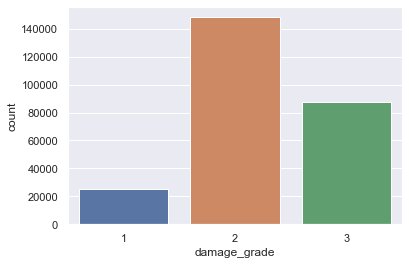

In [11]:
sns.set(style="darkgrid")

ax = sns.countplot(x="damage_grade", data=train_target)

In [15]:
# Metric to be used
# F1 score with argument micro has to be used

In [16]:
from sklearn.metrics import f1_score

f1_score(y_true= , y_pred = average='micro')

## Base line model always predict mode ( class = 2 ) 

In [18]:
# lets see our f1 score (micro) when we always predict the 2nd class

In [19]:
y_true =  train_target.damage_grade
y_pred = [2]*len(y_true)

In [20]:
f1_score(y_true, y_pred, average='micro')

0.5689118614280068

Number 1 on leaderboard score = 0.7544

## check features

In [6]:
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


Feature Description

https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/

### Does buliding ID give us something

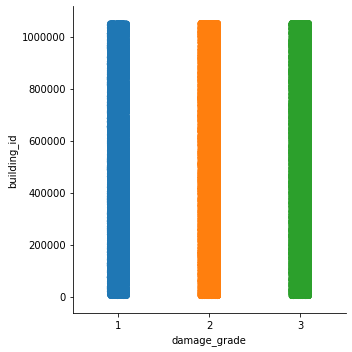

In [16]:
sns.catplot(x="damage_grade", y="building_id", data=train_target);

## Linear model

## Data Processing

In [78]:
def create_X(df):
    X = df.copy()
    cat_cols = X.columns[X.dtypes == 'object']
    num_cols = [i for i in X.columns if i not in cat_cols]
    
    x1 = X[cat_cols].apply(LabelEncoder().fit_transform)
    X = pd.concat([X[num_cols], x1], axis=1)
    
    return X



        


def _new_ids(l1, l2):
    '''l1 and l2 are np.arrays
    l1 = train array
    l2 = test array
    '''
    
    if not isinstance(l1, np.ndarray):
        l1 = np.array(l1)
    if not isinstance(l2, np.ndarray):
        l2 = np.array(l2)
    
    mode = scipy.stats.mode(l1)[0][0]  # mode value of train
    
    bool_arr = np.array([i in l1 for i in l2])
    out = l2.copy()
    out[~bool_arr] = mode
    
    
    return out

def replace_new_ids(train_df, test_df, cols):
    '''
    train_df = train_df
    test_df = test_df
    cols = list of columns which have new ids not in train_df
    
    This function will replace any new values in the cols of 
    test_df with the mode of trains_df
    '''
    for column in cols:
        test_df.loc[:,column] = _new_ids(train_df.loc[:,column], test_df.loc[:,column])
    return train_df, test_df
    
    
def geo23_in_geo1(X_train, X_test):
    ''' Requirement: No new geo_level_2 ids in X_test'''
    
    dic_1_2 = dict(X_train.groupby('geo_level_1_id', as_index=False)['geo_level_2_id'].nunique())
    dic_1_3 = dict(X_train.groupby('geo_level_1_id', as_index=False)['geo_level_3_id'].nunique())
    
    for frame in [X_train, X_test]:
        frame['count12'] = frame.loc[:, 'geo_level_1_id'].apply(lambda x: dic_1_2[x])
        frame['count13'] = frame.loc[:, 'geo_level_1_id'].apply(lambda x: dic_1_3[x])
    
    return X_train, X_test
    



def new_rows(l1, l2):
    s = set(l2) - set(l1)
    return len([i for i in l2 if i in s])

In [79]:
class FreqEncode:
    def __init__(self):
        self.freq_dict = {}
    
    def create_dict(self,train_col):
        return dict(train_col.value_counts())
    
    def fit(self, X_train, cols):
        '''
        X_train = train_df
        cols for which we need to encode frequency
        '''
        self.cols = cols
        for i in cols:
            value = self.create_dict(X_train[i])
            self.freq_dict[i] = value
    
    def transform(self, X_test):
        '''this appends freq encoding columns to X_test inplace'''
        for i in self.cols:
            X_test[i.strip()+'_fq'] = X_test[i].apply(lambda x: self.freq_dict[i][x])
        return X_test
    

In [106]:
X = create_X(df)

In [81]:
X, _ = geo23_in_geo1(X,X)

In [51]:
import scipy

In [52]:
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

X, _ = replace_new_ids(X, X, geo_features)


In [107]:
fe = FreqEncode()
fe.fit(X,geo_features)
X = fe.transform(X)

### RF including only freq encoding

In [109]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)

In [110]:
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.74058341, 0.74092877, 0.74035572])

In [118]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

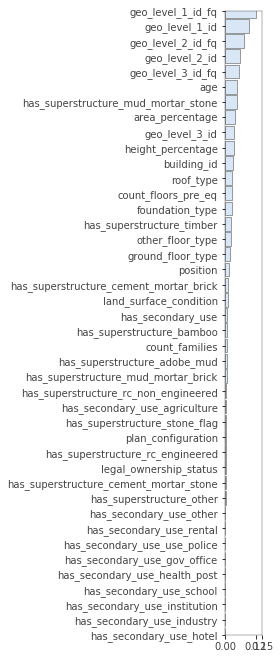

In [119]:
imp = importances(model, X, y) # permutation
viz = plot_importances(imp)

In [ ]:
top20 = imp.iloc[:20].index.tolist()

In [128]:
cross_val_score(estimator=model,X = X[top20], y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.74113598, 0.74030713, 0.74035572])

## RF including count12 and freq encoding

In [83]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)

In [91]:
cross_val_score(estimator=model,X = X[top20], y=y , scoring=scorer, cv=3,n_jobs=-1)

array([0.74114749, 0.74011143, 0.74009095])

In [102]:
top20.remove('geo_level_3_id_fq')
top20.remove('count_floors_pre_eq')
top20.remove('count12')


In [103]:
# after removing the correlated features
cross_val_score(estimator=model,X = X[top20], y=y , scoring=scorer, cv=3,n_jobs=-1)

array([0.7371299 , 0.73651978, 0.73680999])

In [86]:
from rfpimp import *

In [87]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

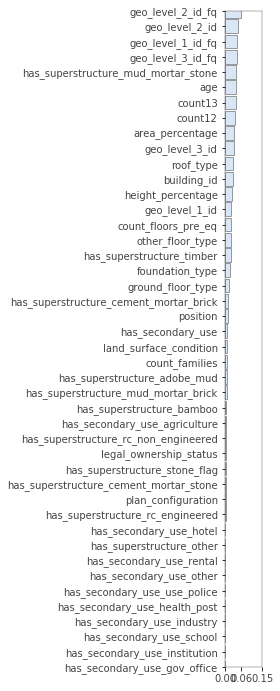

In [88]:
imp = importances(model, X, y) # permutation
viz = plot_importances(imp)

In [90]:
top20 = imp.iloc[:20].index.tolist()

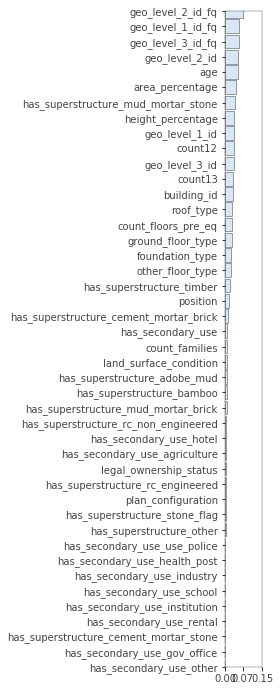

In [81]:
# Pretty much useless

In [88]:
cross_val_score(estimator=estimator,X = X_train[['count_floors_pre_eq','age']], y=y_train, scoring=scorer, cv=3)

array([0.56831054, 0.56859833, 0.56833017])

## Random Forest

In [13]:
estimator = RandomForestClassifier(n_estimators=50,min_samples_leaf=1, n_jobs=-1)

In [12]:
cross_val_score(estimator=estimator,X=X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.71525763, 0.71781323, 0.71927704])

In [16]:
np.mean(np.array([0.71525763, 0.71781323, 0.71927704]))

0.7174493000000001

`estimator = RandomForestClassifier(n_estimators=10,min_samples_leaf=1)`  array([0.69160105, 0.69367316, 0.69515916])

`estimator = RandomForestClassifier(n_estimators=50,min_samples_leaf=1, n_jobs=-1)`  array([0.71525763, 0.71781323, 0.71927704])

` RandomForestClassifier(n_estimators=30,min_samples_leaf=1) ` [0.71034213, 0.71319703, 0.71529385] 

` random on one-hot encoding `
array([0.65804439, 0.65726159, 0.6648017 ])

In [109]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)

In [110]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

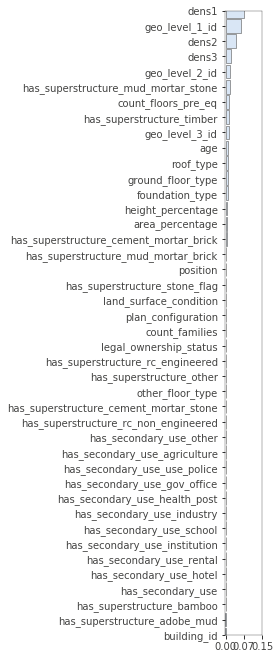

In [113]:
imp = importances(model, X_test, y_test) # permutation
viz = plot_importances(imp)

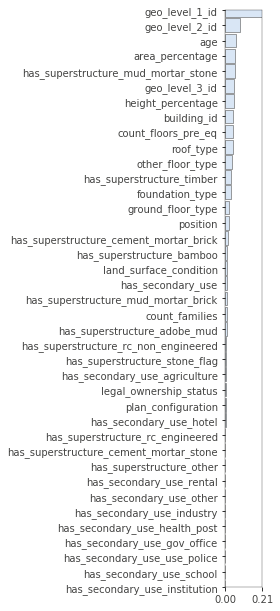

In [26]:
imp = importances(model, X_train, y_train) # permutation
viz = plot_importances(imp)

In [116]:
top20_features = imp.index[:20]

In [117]:
# use only top 10 features

In [119]:
cross_val_score(estimator=model,X = pd.concat([X_train, X_test])[top20_features], y=pd.concat([y_train, y_test]), scoring=scorer, cv=3,n_jobs=-1)

array([0.74003085, 0.74097481, 0.73847925])

### best score

frequency encoding of the geo features

In [134]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)

In [135]:
cross_val_score(estimator=model,X = pd.concat([X_train, X_test])[top20_features], y=pd.concat([y_train, y_test]), scoring=scorer, cv=3,n_jobs=-1)

array([0.74426716, 0.74419809, 0.74108099])

In [133]:
np.array([0.74245982, 0.74248285, 0.7376734 ]).mean()

0.7408720233333334

In [54]:
# <70 for top 10 features
# 72.2 for top 20 features
# 72.2 for top 30 features


In [55]:
# are there any better ways to represent features.

In [56]:
imp.index[:10]

Index(['geo_level_1_id', 'geo_level_2_id',
       'has_superstructure_mud_mortar_stone', 'count_floors_pre_eq',
       'roof_type', 'height_percentage', 'has_superstructure_timber',
       'geo_level_3_id', 'other_floor_type', 'age'],
      dtype='object', name='Feature')

In [47]:
frame = pd.concat([geo,pd.DataFrame(y)],axis=1)

In [54]:
import matplotlib.pyplot as plt

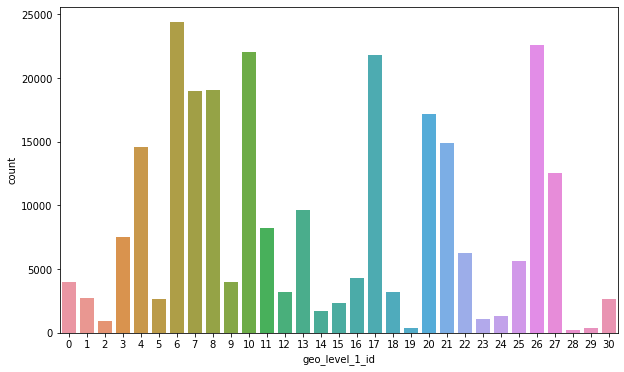

In [77]:
plt.figure(figsize=(10,6))
_ = sns.countplot(x='geo_level_1_id', data=frame)

In [87]:
x = true_test.groupby('geo_level_3_id',as_index=False)['building_id'].count()
x.sort_values('building_id',ascending=False,inplace=True)
x = x.iloc[:50]


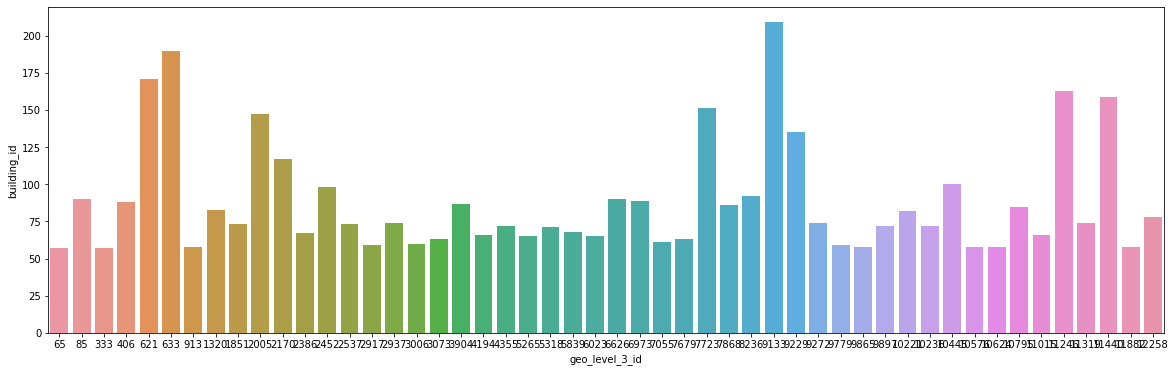

In [88]:
plt.figure(figsize=(20,6))
_ = sns.barplot(x='geo_level_3_id', y='building_id', data=x)

In [89]:
x = X.groupby('geo_level_3_id',as_index=False)['building_id'].count()
x.sort_values('building_id',ascending=False,inplace=True)

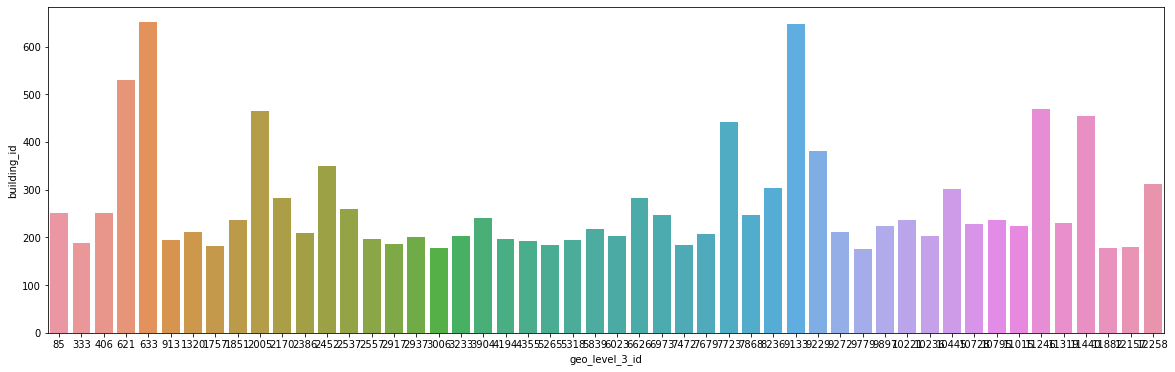

In [90]:
x = x.iloc[:50]


plt.figure(figsize=(20,6))
_ = sns.barplot(x='geo_level_3_id', y='building_id', data=x)

In [91]:
# all the 3 geo locations seem to be consistent within in train and test sets

In [94]:
col = X.geo_level_1_id

In [286]:
true_test = pd.read_csv('../input/test_values.csv')

In [287]:
true_test = create_X(true_test)

In [288]:
from scipy import stats

In [294]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)

In [214]:
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.74092877, 0.74099784, 0.74085075])

In [296]:
model.fit(X[top20_features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [298]:
preds = model.predict(true_test[top20_features])

In [303]:
Counter(preds)

Counter({3: 24210, 2: 56831, 1: 5827, 'normalize': 1})

In [301]:
Counter(y)

Counter({3: 87218, 2: 148259, 1: 25124})

In [304]:
give_sub_file(preds, true_test.building_id.tolist(), path='../output/mode_values.csv')

Index(['building_id', 'damage_grade'], dtype='object')
(86868, 2)


In [ ]:
# Adding density features impacted the model

In [ ]:
# corr plot

In [393]:
corr_thres(X[top20_features], 0.7)

,col1,col2,correlation
0,dens2,dens3,0.798697
1,count_floors_pre_eq,height_percentage,0.772734


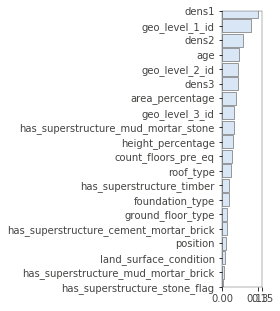

In [397]:
imp = importances(model, X_train[top20_features], y_train) # permutation
viz = plot_importances(imp)

In [398]:
corr_features = ['count_floors_pre_eq','dens3']

In [399]:
top18 = [i for i in top20_features if i not in corr_features]

In [400]:
len(top18)

18

In [314]:
##ilocdd the geo2 and geo 3 locations in geo1 as a feature

In [402]:
cross_val_score(estimator=model,X = X[top18], y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.74084818, 0.7402726 , 0.7402406 ])

In [413]:
X, true_test = geo23_in_geo1(X_train, X_test)

/data/nithish/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/data/nithish/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [417]:
 pd.concat([X_train, X_test],axis=0).shape

(260601, 44)

In [ ]:
model = 

In [424]:
cross_val_score(estimator=model,X =, 
                y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.54382511, 0.54534466, 0.54531745])

## XGBOOST

In [16]:
from xgboost import XGBClassifier

In [17]:
xgb = XGBClassifier(n_estimators=30,subsample=0.3)

In [18]:
cross_val_score(estimator=xgb,X = X_train, y=y_train, scoring=scorer, cv=3,n_jobs=-1)

array([0.64708523, 0.64614127, 0.64909918])